# =====================================================
#  SENTIMENT ANALYSIS - LSTM MODEL
# =====================================================

In [2]:
import os
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.models import Sequential


In [3]:

# ------------------------
# SETUP
# ------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = r'/kaggle/input/bersih-cleaned-text-sentimentlabeled-updated/bersih_cleaned_text_Sentimentlabeled_updated.csv'

MAX_WORDS = 25000
MAX_LEN = 100
EMB_DIM = 200
EPOCHS = 2   ################################################################################################################################3
BATCH_SIZE = 64
LR = 1e-3  # Fixed learning rate

In [4]:


# ------------------------
# 1️⃣ Load Data
# ------------------------
df = pd.read_csv(DATA_PATH)
df = df[['clean_text', 'inset_sentiment']].dropna()
df['inset_sentiment'] = df['inset_sentiment'].str.lower().str.strip()

label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df = df[df['inset_sentiment'].isin(label_map.keys())]
df['label'] = df['inset_sentiment'].map(label_map)

print("Dataset shape:", df.shape)
print("Label distribution:\n", df['inset_sentiment'].value_counts())


Dataset shape: (12458, 3)
Label distribution:
 inset_sentiment
negatif    4707
positif    4707
netral     3044
Name: count, dtype: int64


In [5]:

# ------------------------
# 2️⃣ Tokenization
# ------------------------
texts = df['clean_text'].astype(str).tolist()
labels = df['label'].values

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = labels

In [6]:

# ------------------------
# 3️⃣ Split Data
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (9966, 100) Test: (2492, 100)


In [7]:

# ------------------------
# 4️⃣ Build LSTM Model (Train from scratch)
# ------------------------
model = Sequential([
    Embedding(input_dim=min(MAX_WORDS, len(tokenizer.word_index)+1),
              output_dim=EMB_DIM,
              input_length=MAX_LEN,
              trainable=True),  # learn from scratch
    SpatialDropout1D(0.5),   ################################################################################################################################3
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),  ################################################################################################################################3
    Dense(128, activation='relu'),
    Dropout(0.5),   ################################################################################################################################3
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_LEN))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1761073889.016879    1417 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 200)       │     4,266,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,784,947 (18.25 MB)

 Trainable params: 4,784,947 (18.25 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ------------------------
# 5️⃣ Train Model (NO callbacks)
# ------------------------
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

Epoch 1/2


I0000 00:00:1761073897.304648    1467 cuda_dnn.cc:529] Loaded cuDNN version 90300


141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4799 - loss: 1.0226 - val_accuracy: 0.6590 - val_loss: 0.7590
Epoch 2/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6993 - loss: 0.6783 - val_accuracy: 0.7131 - val_loss: 0.6723


In [10]:

# ------------------------
# 6️⃣ Evaluate
# ------------------------
y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negatif','netral','positif']))


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

✅ Test Accuracy: 0.7063

Classification Report:
              precision    recall  f1-score   support

     negatif       0.84      0.74      0.79       942
      netral       0.47      0.45      0.46       609
     positif       0.73      0.84      0.78       941

    accuracy                           0.71      2492
   macro avg       0.68      0.68      0.68      2492
weighted avg       0.71      0.71      0.70      2492



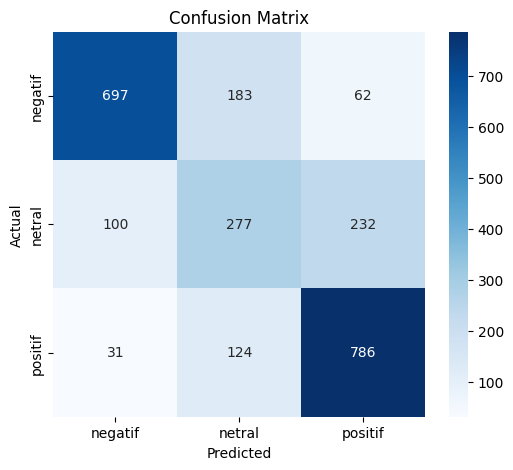

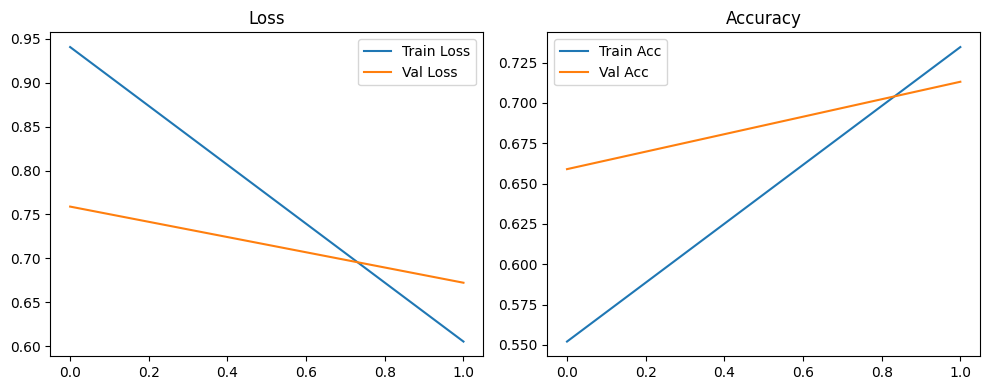

In [11]:

# ------------------------
# 7️⃣ Confusion Matrix
# ------------------------
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif','netral','positif'],
            yticklabels=['negatif','netral','positif'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 8️⃣ Learning Curves
# ------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()


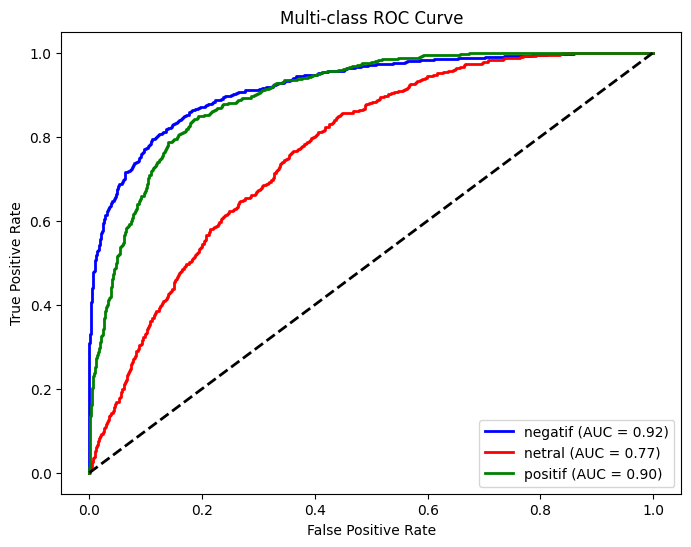

Macro ROC-AUC: 0.8635
Weighted ROC-AUC: 0.8762


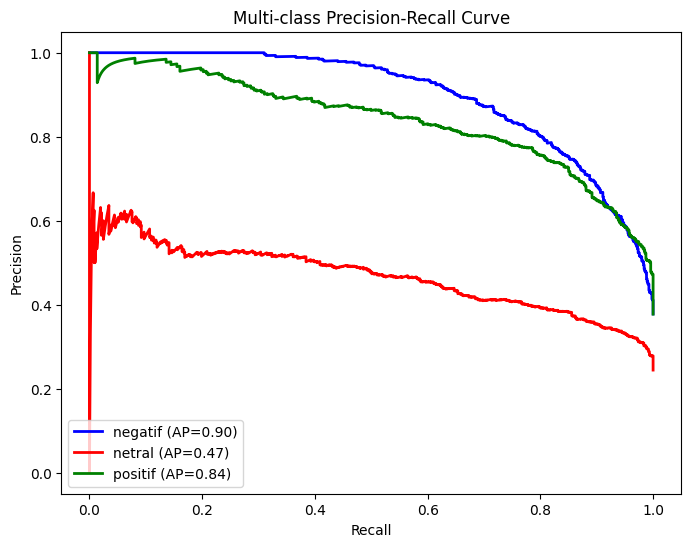

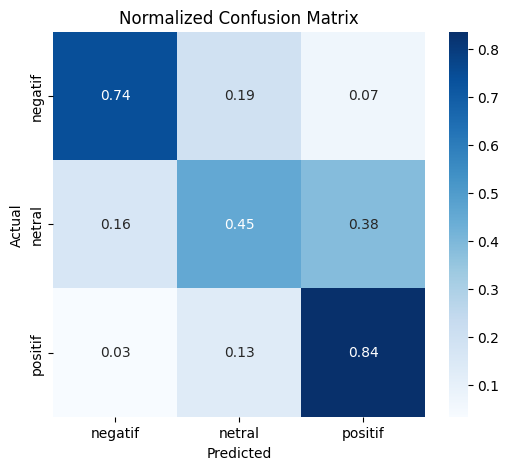

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from itertools import cycle

# ------------------------
# 1️⃣ One-hot encode labels for ROC/AUC
# ------------------------
num_classes = 3
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# ------------------------
# 2️⃣ ROC Curve & AUC (multi-class)
# ------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['blue', 'red', 'green'])

plt.figure(figsize=(8,6))
for i, color in zip(range(num_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{['negatif','netral','positif'][i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Macro & Weighted AUC
macro_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr', average='macro')
weighted_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr', average='weighted')
print(f"Macro ROC-AUC: {macro_auc:.4f}")
print(f"Weighted ROC-AUC: {weighted_auc:.4f}")

# ------------------------
# 3️⃣ Precision-Recall Curve
# ------------------------
plt.figure(figsize=(8,6))
for i, color in zip(range(num_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f"{['negatif','netral','positif'][i]} (AP={avg_prec:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# ------------------------
# 4️⃣ Normalized Confusion Matrix
# ------------------------
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['negatif','netral','positif'],
            yticklabels=['negatif','netral','positif'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()
